## Using Multiple Outcomes to Improve the Synthetic Control Method

### Motivations

In many applications, researchers are interested in multiple outcome series at once. There is limited practical guidance for using SCM in this common setting, however, and researchers generally default to estimating separate weights for each outcome.
    
This separate SCM approach can run into two main challenges:

+ At one extreme, poor pre-treatment fit, which is more likely with longer series, can lead to bias.

+ At the other extreme, perfect or near-perfect pre-treatment fit, which is more likely with shorter series, can lead to finding SCM weights that overfit to idiosyncratic errors.


In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

We consider a simiple model of $k^{th}$ outcome under conrol,

$$
Y_{itk}(0) = \phi_i \mu_t + \epsilon_{itk}
$$

where $\phi_i$ is a scalar and $\epsilon_{itk} \sim \mathcal{N}(0,1)$. 

+ Set the factor values $\mu_t$ to be evenly spaced over interval [0.5, 1] for $t=1,\cdots,T_0+1$, reflecting a upward time trend.

+ The factor loading $\phi_i$ are evenly spaced over the interval [1, 5] for $i=1, \cdots, N$.

+ Set the treated unit to be the unit with the second largest factor loading.

In [19]:
# define a function to generate data
def gen_outcome(N, T0, T1, D):
    np.random.seed()
    # factor value
    mu_t = np.linspace(0.5, 1, T0+T1)
    # factor loading
    phi_i = np.linspace(1, 5, N)
    # noise
    epsilon_it = np.random.normal(0, 1, (N, T0+T1))

    # gen outcome 
    outcome = phi_i.reshape(-1, 1) * mu_t.reshape(1, -1) + epsilon_it
    # treated unit is the one with the second largest factor loading
    treated = outcome[-2, :] + np.concatenate([np.zeros(T0), np.ones(T1)*D]).reshape(1, -1)

    outcome = np.concatenate((outcome, treated), axis=0)  

    return outcome

# Notice: the last row of generated data is the observed outcome of the treated unit, the third to last row is the unobserved potential outcome of the treated unit

+ To ensure that the multiple outcomes have similar variance, we standardize each outcome series using its pre-treatment standard deviation.


+ We focus on the de-meaned or intercept-shifted weighting estimators (DIFP) (Doudchenko and Imbens, 2017; Ferman and Pinto, 2021).

\begin{equation}
\tag{1}
\hat{Y}_{1Tk}(0) \equiv \bar{Y}_{1\cdot k} + \sum_{i=2}^{N} \gamma_i \dot{Y}_{iTk},
\end{equation}

where $\bar{Y}_{it} \equiv \frac{1}{T_0} \sum_{t=1}^{T_0} Y_{itk} $, and $\dot{Y}_{itk} = Y_{itk} - \bar{Y}_{ik} $

In [20]:
N = 50
T0 = 10
T1 = 1
K = 5
df = np.empty((K, N+1, T0+T1))

for k in range(K):
    # generate data
    data = gen_outcome(N, T0, T1, 2*(k+1))

    # standardize all the outcome series using the pre-treatment standard deviation
    data /= data[:, :T0].std(axis=1).reshape(-1, 1)

    # compute mean for pre-treatment period
    mean_ = data[:, :T0].mean(axis=1).reshape(-1, 1)

    # de-mean outcome
    data -= mean_
    # reserve the de-meaned data for later use
    df[k] = data

In [21]:
# check the head of first k=0 data
pd.DataFrame(df[0]).head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.316943,-1.292870,-0.769553,1.190491,-0.853115,-0.872520,0.654876,1.289199,0.294609,-0.958060,-0.756840
1,0.200559,-1.341967,0.104258,0.536077,1.327886,1.659394,-0.601904,-1.392731,-0.924377,0.432805,1.924720
2,0.527282,-0.062359,-1.396505,-0.138027,-0.829859,-0.261559,-0.907993,-0.390022,1.857344,1.601698,0.833433
3,0.448667,0.213473,-0.147395,1.804800,-0.604166,-0.562707,1.201208,0.491926,-1.252249,-1.593557,1.113169
4,-1.167983,0.341638,0.072061,-0.566757,0.813735,-1.286235,1.873911,-1.102953,1.070416,-0.047834,0.664383


### Seperated objective
We compute the synthetic control weights for each outcome series seperately. The objective function is:
    
$$
q_{k}^{sep}(\gamma) = \sqrt{ \frac{1}{T_0} \sum_{t=1}^{T_0} \left( \dot{Y}_{1tk} - \sum_{W_i=0} \gamma_i \dot{Y}_{itk} \right)^2 }

$$

The weights that minimize this objective are the synthetic control weights:

$$
\hat{\gamma}_{k}^{sep} = \argmin_{\gamma \in \Delta_{N_0}} q_{k}^{sep}(\gamma)^2.
$$


In [22]:
from sklearn.utils.validation import check_X_y
from scipy.optimize import minimize, LinearConstraint

In [23]:
# define a function to estimate synthetic weights
def synth(con, tre):

    # get ready for input
    X, y = check_X_y(con.T, tre)

    # define objective function
    def objective_fun(gama, X, y):
        return np.mean((y - X.dot(gama))**2)

    # define constraint
    constraint = LinearConstraint(np.ones(X.shape[1]), lb=1, ub=1)
    # define bounds
    bounds = bounds = ((0, 1),) * X.shape[1]
    # initial weights 
    gama0 = np.ones(X.shape[1])/X.shape[1]

    res = minimize(objective_fun, x0=gama0, args=(X, y), method='SLSQP', constraints=constraint, bounds=bounds)
    return res.x

In [24]:
sep_gamma = []
for k in range(K):
    # treated is the one with the second largest factor loading
    y = df[k][-1, :T0].copy()
    # the remainings are the control units
    X = np.delete(df[k], [-1, -3], axis=0)[:, :T0].copy()

    # estimate synthetic weights
    gama = synth(X, y)
    sep_gamma.append(gama)

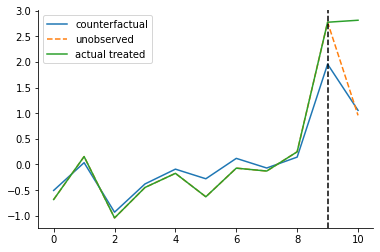

In [25]:
counterfactual = np.delete(df[0], [-1, -3], axis=0).T @ sep_gamma[0]

plt.plot(counterfactual, label='counterfactual')
plt.plot(df[0][-3], label='unobserved', linestyle='--')
plt.plot(df[0][-1], label='actual treated')

plt.axvline(x=T0-1, color='black', linestyle='--')
plt.legend()
sns.despine()

In [26]:
sep_att = []
for k in range(5):

    fitted = np.delete(df[k], [-1, -3], axis=0).T @ sep_gamma[k]
    actual = df[k][-1, :] 

    att = np.mean(actual[T1:] - fitted[T1:])
    sep_att.append(att)
sep_att_mean = np.mean(sep_att)
print('The seperated synthetic control estimate of ATT is', sep_att_mean.round(3))

The seperated synthetic control estimate of ATT is 0.479


In [27]:
# real att is 
real_att = []
for k in range(5):
    unobserved = df[k][-3, :]
    actual = df[k][-1, :]
    att = np.mean(actual[T1:] - unobserved[T1:])
    real_att.append(att)
real_att_mean = np.mean(real_att)
print('The real ATT is', real_att_mean.round(3))

The real ATT is 0.487


### Concatenated objective

$$
q^{cat}(\gamma) = \sqrt{\frac{1}{T_0 K} \sum_{k=1}^{K} \sum_{t=1}^{T_0} \left( \dot{Y}_{1tk} - \sum_{\substack{W_i=0}} \gamma_i \dot{Y}_{itk} \right)^2 },
$$

with corresponding weightss:

$$
\hat{\gamma}^{cat} \equiv \underset{\gamma \in C}{\arg\min} \quad q^{cat}(\gamma^2)
$$

In [28]:
# picked out treated and control groups for pre-treatment period, and concatenate them separately
X = np.empty((N-1, 0))
y = np.empty((0,))
for k in range(5):
    treated = df[k][-1, :T0].copy()
    control = np.delete(df[k], [-1, -3], axis=0)[:, :T0].copy()
    X = np.concatenate([X, control], axis=1)
    y = np.concatenate([y, treated], axis=0)

In [29]:
conca_gama = synth(X, y)

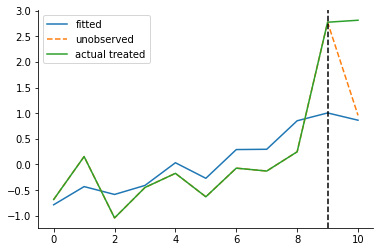

In [30]:
plt.plot(np.delete(df[0], [-1, -3], axis=0).T @ conca_gama, label='fitted')
plt.plot(df[0][-3], label='unobserved', linestyle='--')
plt.plot(df[0][-1], label='actual treated')

plt.axvline(x=T0-1, color='black', linestyle='--')
plt.legend()
sns.despine()

In [31]:
conca_residual = []
for k in range(5):
    fitted = np.delete(df[k], [-1, -3], axis=0).T @ conca_gama
    actual = df[k][-1, :]
    residule = np.mean(actual[T1:] - fitted[T1:])
    conca_residual.append(residule)
conca_att = np.mean(conca_residual)
print('The concatenated synthetic control estimate of ATT is', conca_att.round(3))

The concatenated synthetic control estimate of ATT is 0.455


### Averaged objective

The averaged objective:

$$
q^{avg}(\gamma) = \sqrt{ \frac{1}{T_0} \sum_{t=1}^{T_0} \left( \frac{1}{K} \sum_{k=1}^{K} \dot{Y}_{1tk} - \sum_{W_i=0} \gamma_i \dot{Y}_{itk} \right)^2 },
$$

with corresponding weights:

$$
\hat{\gamma}^{avg} \equiv \underset{\gamma \in C}{\arg\min} q^{avg}(\gamma)^2
$$

In [32]:
# picked out treated unit for pre-treatment period, and compute the mean
y = np.empty((T0, 0))
X = np.empty((5, N-1, T0))

for k in range(5):
    treated = df[k][-1, :T0].reshape(-1, 1)
    y = np.concatenate([y, treated], axis=1)
    X[k] = np.delete(df[k], [-1, -3], axis=0)[:, :T0]

# compute the mean
y = y.mean(axis=1)
X = X.mean(axis=0)

In [33]:
avg_gama = synth(X, y)

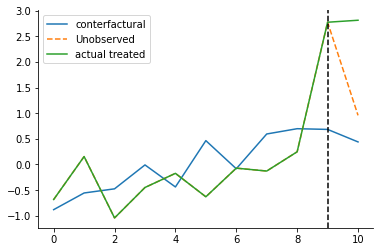

In [34]:
plt.plot(np.delete(df[0], [-1, -3], axis=0).T @ avg_gama, label='conterfactural')
plt.plot(df[0][-3], label='Unobserved', linestyle='--')
plt.plot(df[0][-1], label='actual treated')

plt.axvline(x=T0-1, color='black', linestyle='--')
plt.legend()
sns.despine()

In [35]:
avg_residual = []
for k in range(5):
    fitted = np.delete(df[k], [-1, -3], axis=0).T @ avg_gama
    actual = df[k][-1, :]
    residual = np.mean(actual[T1:] - fitted[T1:])
    avg_residual.append(residual)
avg_att = np.mean(avg_residual)
print('The averaged synthetic control estimate of ATT is', avg_att.round(3))

The averaged synthetic control estimate of ATT is 0.461


### Monte Carlo simulation to compute the bias distribution across 3 approches

In [36]:
# define a function to prepare to data
def prepare_data(N, T0, T1, K):
    df = np.empty((K, N+1, T0+T1))

    for k in range(K):
        # generate data
        data = gen_outcome(N, T0, T1, 2*(k+1))

        # standardize all the outcome series using the pre-treatment standard deviation
        data /= data[:, :T0].std(axis=1).reshape(-1, 1)

        # compute mean for pre-treatment period
        mean_ = data[:, :T0].mean(axis=1).reshape(-1, 1)

        # de-mean outcome
        data -= mean_
        # reserve the de-meaned data for later use
        df[k] = data
    return df

In [37]:
# define a function compute the ATT by seperated synthetic control method
def sep_syn(df, K):
    sep_gamma = []
    for k in range(K):
        # treated is the one with the second largest factor loading
        y = df[k][-1, :T0].copy()
        # the remainings are the control units
        X = np.delete(df[k], [-1, -3], axis=0)[:, :T0].copy()

        # estimate synthetic weights
        gama = synth(X, y)
        sep_gamma.append(gama)

    sep_att = []
    for k in range(K):

        fitted = np.delete(df[k], [-1, -3], axis=0).T @ sep_gamma[k]
        actual = df[k][-1, :] 

        att = np.mean(actual[T1:] - fitted[T1:])
        sep_att.append(att)
    sep_att_mean = np.mean(sep_att)
    return sep_att_mean

In [38]:
# define a function to compute the ATT by concatenated synthetic control method
def conca_syn(df, K):
    X = np.empty((N-1, 0))
    y = np.empty((0,))
    for k in range(K):
        treated = df[k][-1, :T0].copy()
        control = np.delete(df[k], [-1, -3], axis=0)[:, :T0].copy()
        X = np.concatenate([X, control], axis=1)
        y = np.concatenate([y, treated], axis=0)

        conca_gama = synth(X, y)

    conca_att = []
    for k in range(K):
        fitted = np.delete(df[k], [-1, -3], axis=0).T @ conca_gama
        actual = df[k][-1, :]
        att = np.mean(actual[T1:] - fitted[T1:])
        conca_att.append(att)
    conca_att_mean = np.mean(conca_att)
    return conca_att_mean

In [39]:
# define a function to compute the ATT by averaged synthetic control method
def avg_syn(df, K):
    y = np.empty((T0, 0))
    X = np.empty((K, N-1, T0))

    for k in range(K):
        treated = df[k][-1, :T0].reshape(-1, 1)
        y = np.concatenate([y, treated], axis=1)
        X[k] = np.delete(df[k], [-1, -3], axis=0)[:, :T0]

    # compute the mean
    y = y.mean(axis=1)
    X = X.mean(axis=0)

    avg_gama = synth(X, y)
    avg_att = []
    for k in range(K):
        fitted = np.delete(df[k], [-1, -3], axis=0).T @ avg_gama
        actual = df[k][-1, :]
        att = np.mean(actual[T1:] - fitted[T1:])
        avg_att.append(att)
    avg_att_mean = np.mean(avg_att)
    return avg_att_mean

In [40]:
# define a function to compute the real unobserved ATT 
def real_ATT(df, K):
    real_att = []
    for k in range(K):
        real = df[k][-3, :]
        actual = df[k][-1, :]
        att = np.mean(actual[T1:] - real[T1:])
        real_att.append(att)
    real_att_mean = np.mean(real_att)
    return real_att_mean

In [41]:
N = 50
T0 = 10
T1 = 1
K = 4
df = np.empty((K, N+1, T0+T1))

# Monte Carlo simulation compute bias
sep_bias1 = []
conca_bias1 = []
avg_bias1 = []

for i in range(500):
    df = prepare_data(N, T0, T1, K)
    sep_att_mean = sep_syn(df, K)
    conca_att_mean = conca_syn(df, K)
    avg_att_mean = avg_syn(df, K)
    real_att_mean = real_ATT(df, K)

    sep_bias1.append(sep_att_mean - real_att_mean)
    conca_bias1.append(conca_att_mean - real_att_mean)
    avg_bias1.append(avg_att_mean - real_att_mean)

In [42]:
N = 50
T0 = 10
T1 = 1
K = 10
df = np.empty((K, N+1, T0+T1))

# Monte Carlo simulation compute bias
sep_bias2 = []
conca_bias2 = []
avg_bias2 = []

for i in range(500):
    df = prepare_data(N, T0, T1, K)
    sep_att = sep_syn(df, K)
    conca_att = conca_syn(df, K)
    avg_att = avg_syn(df, K)
    real_att = real_ATT(df, K)

    sep_bias2.append(sep_att - real_att)
    conca_bias2.append(conca_att - real_att)
    avg_bias2.append(avg_att - real_att)

In [43]:
N = 50
T0 = 40
T1 = 1
K = 4
df = np.empty((K, N+1, T0+T1))

# Monte Carlo simulation compute bias
sep_bias3 = []
conca_bias3 = []
avg_bias3 = []

for i in range(1000):
    df = prepare_data(N, T0, T1, K)
    sep_att = sep_syn(df, K)
    conca_att = conca_syn(df, K)
    avg_att = avg_syn(df, K)
    real_att = real_ATT(df, K)

    sep_bias3.append(sep_att - real_att)
    conca_bias3.append(conca_att - real_att)
    avg_bias3.append(avg_att - real_att)

In [44]:
N = 50
T0 = 40
T1 = 1
K = 10
df = np.empty((K, N+1, T0+T1))

# Monte Carlo simulation compute bias
sep_bias4 = []
conca_bias4 = []
avg_bias4 = []

for i in range(1000):
    df = prepare_data(N, T0, T1, K)
    sep_att = sep_syn(df, K)
    conca_att = conca_syn(df, K)
    avg_att = avg_syn(df, K)
    real_att = real_ATT(df, K)

    sep_bias4.append(sep_att - real_att)
    conca_bias4.append(conca_att - real_att)
    avg_bias4.append(avg_att - real_att)

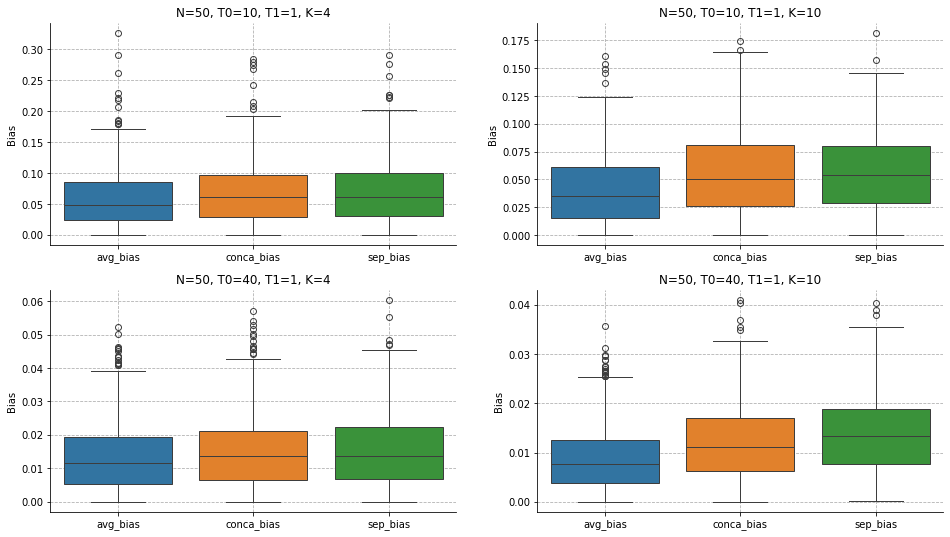

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))
data = pd.DataFrame({'avg_bias': avg_bias1, 'conca_bias': conca_bias1, 'sep_bias': sep_bias1}).abs()
sns.boxplot(data=data.melt(), x='variable', y='value', hue='variable', ax=ax[0, 0])
ax[0, 0].set_title('N=50, T0=10, T1=1, K=4')

data = pd.DataFrame({'avg_bias': avg_bias2, 'conca_bias': conca_bias2, 'sep_bias': sep_bias2}).abs()
sns.boxplot(data=data.melt(), x='variable', y='value', hue='variable', ax=ax[0, 1])
ax[0, 1].set_title('N=50, T0=10, T1=1, K=10')

data = pd.DataFrame({'avg_bias': avg_bias3, 'conca_bias': conca_bias3, 'sep_bias': sep_bias3}).abs()
sns.boxplot(data=data.melt(), x='variable', y='value', hue='variable', ax=ax[1, 0])
ax[1, 0].set_title('N=50, T0=40, T1=1, K=4')

data = pd.DataFrame({'avg_bias': avg_bias4, 'conca_bias': conca_bias4, 'sep_bias': sep_bias4}).abs()
sns.boxplot(data=data.melt(), x='variable', y='value', hue='variable', ax=ax[1, 1])
ax[1, 1].set_title('N=50, T0=40, T1=1, K=10')

for i in range(2):
    for j in range(2):
        ax[i, j].grid(linestyle='--')
        ax[i, j].set_xlabel('')
        ax[i, j].set_ylabel('Bias')
sns.despine()

### Problem setup

Consider panel data setting of $N$ units, $T$ time periods, and $K$ outcomes $Y_{itk}$. We observe the outcome 
$$
Y_{itk} = (1 - W_i)Y_{itk}(0) + W_i \mathbb{1}\{t \leq T_0\}Y_{itk}(0) + W_i \mathbb{1}\{t > T_0\}Y_{itk}(1).
$$



### Identification

``Assumption 1:`` The outcome under control is generated as

$$
Y_{itk}(0) = \alpha_{ik} + \beta_{tk} + L_{itk} + \epsilon_{itk}
$$

The bias of a de-meaned weighting estimator under assumption 1:

\begin{equation}
\tag{2}
\mathbb{E}_{\epsilon_T} \left[ Y_{1Tk}(0) - \hat{Y}_{1Tk}(0) \right] = \beta_{Tk} \left( 1 - \sum_{i=2}^{N} \gamma_i \right) + L_{1Tk} - \sum_{i=2}^{N} \gamma_i L_{iTk},
\end{equation}

weights $\gamma$ will lead to an unbiased estimator for time $t$ and outcome $k$ if;

+ The weights sum to one

+ The weighted average of the latent $L_{itk}$ for the donor units equals $L_{1tk}$.

`Definition 1:` (Oracle weights) The oracle weights $\gamma^*$ solve the following system of $(TK) + 1$ equations:

\begin{equation}
\tag{3}
\left( L \quad 1_N \right)' 

\left( \begin{array}{c} 
-1 \\ 
\gamma^* 
\end{array} \right) 

= \mathbb{0}_{T_K},
\end{equation}

`Assumption 2a:` (Low-rank $L$) The $N\times (TK)$ matrix of model components has reduced rank, that is:

$$
rank(L) < N- 1
$$

`Proposition 1:` (Low-rank is sufficient and necessary) The unconstrained oracle weights $\gamma^*$ exist iff Assumption 2a holds.

Under Assumption 2a, for $r=rank(L)$ the deterministic model component can be written as a linear factor model:
\begin{equation}
\tag{4}
L_{itk} = \phi_i \dot \mu_{tk}
\end{equation}

Where $\mu_{tk} \in \mathbb{R}_r$ are latent time- and outcome-specific factors, $\phi_i \in \mathbb{R}^r$ are factor loadings. Propostion 1 guarantees that the oracle weights exist and solve:

$$
\phi_1 = \Phi_0^{tr}\gamma^*
$$



A special case that satisfies Assumption 2a is when $L_{itk}$ can be decomposed into a common and idiosyncratic component:

\begin{equation}
\tag{5}
L_{itk} = \sum_{f=1}^{r_0} \phi_{cf} \mu_{tkf} + \sum_{f=r_0+1}^{r_k} \phi_{kf} \mu_{ktf},
\end{equation}

where $\phi_{cf}$ and $\phi_{kf}$ are orthogonal. Then:
$$
rank(L) = r_0 + \sum_{k=1}^K(r_k - r_0)
$$
To satisfy Assumption 2a, we need $K$ is relatively small or $r_0$ is large relatively to $r_k$.

`Assumption 2b:` 

Assume $rank(L) < N − 1$ and assume there is a known $C$ such that some oracle weights exist in a set $C$ where $||x||_1<C$ for all $x \in C$. Denote $\gamma^*$ as a solution to Equation (3) in $C$.

### Estimation

The concatenated objective:

$$
q^{cat}(\gamma) = \sqrt{\frac{1}{T_0 K} \sum_{k=1}^{K} \sum_{t=1}^{T_0} \left( \dot{Y}_{1tk} - \sum_{\substack{W_i=0}} \gamma_i \dot{Y}_{itk} \right)^2 },
$$

with corresponding weightss:

$$
\hat{\gamma}^{cat} \equiv \underset{\gamma \in C}{\arg\min} q^{cat}(\gamma^2)
$$


The averaged objective:

$$
q^{avg}(\gamma) = \sqrt{ \frac{1}{T_0} \sum_{t=1}^{T_0} \left( \frac{1}{K} \sum_{k=1}^{K} \dot{Y}_{1tk} - \sum_{W_i=0} \gamma_i \dot{Y}_{itk} \right)^2 },
$$

with corresponding weights:

$$
\hat{\gamma}^{avg} \equiv \underset{\gamma \in C}{\arg\min} q^{avg}(\gamma)^2
$$

### Estimation error

Estimation error:

\begin{equation*}
\begin{split}

\tau_k - \hat{\tau}_k(\hat{\gamma}) &= \bar{Y}_{1Tk}(0) - \sum_{i=2}^{N} \hat{\gamma}_i \bar{Y}_{itk} \\

&= \underbrace{L_{1Tk} - \sum_{i=2}^{N} \hat{\gamma}_i L_{iTk}}_{\text{bias = imbalance + overfitting}} + \underbrace{\epsilon_{1Tk} - \sum_{i=2}^{N} \hat{\gamma}_i \dot{\epsilon}_{iTk}}_{\text{noise}}. 

\end{split}
\end{equation*}

The noise term is due to post-treatment idiosyncratic errors and is common across the different approaches for choosing weights. The first term can be decomposed int:

\begin{align}
L_{1Tk} - \sum_{W_i=0} \hat{\gamma}_i L_{iTk} = \sum_{t=1}^{T_0} \sum_{j=1}^{K} \omega_{tj} \left( \dot{Y}_{1tj} - \sum_{W_i=0} \hat{\gamma}_i \dot{Y}_{itj} \right) \quad (R_0) \tag{6}\\
- \sum_{t=1}^{T_0} \sum_{j=1}^{K} \omega_{tk} \left( \dot{\epsilon}_{1tj} - \sum_{W_i=0} \hat{\gamma}_i \dot{\epsilon}_{itj} \right) \quad (R_1) \tag{7}
\end{align}



### Bias bouds

`Assumption 3:` The idiosyncratic errors $\epsilon_{itk}$ are sub-Gaussian random variables with scale parameter $\sigma$.

`Assumption 4:` Denote $\mu_{tk} \in \mathbb{R}$ as the time-outcome factors from Equation (4) and assume that they are bounded above by $M$. Furthermore, denoting $\sigma_{min}(A)$ as the smallest singular value of a matrix A, assume that:
+ $\sigma_{\min} \left( \frac{1}{T_0} \sum_t \mu_{tk} \mu'_{tk} \right) \geq \xi^{sep} > 0
$ for all outcomes $k=1, \cdots, K$

+ $\sigma_{\min} \left( \frac{1}{T_0K} \sum_{tk} \mu_{tk} \mu'_{tk} \right) \geq \xi^{cat} > 0
$ 

+ $\sigma_{\min} \left( \frac{1}{T_0} \sum_{t} \mu_{t} \mu'_{t} \right) \geq \xi^{avg} > 0
$ 

`Theorem 1:` Suppose Assumptions 1, 2b, 3 and 4 hold. Recall that by construction, the estimated weights satisfy $||\hat{\gamma}||_1<C$ and Assumption 2b implies $||\gamma^*||_1 \leq C$. Let $\tilde{\sigma}=(1+1/\sqrt{T_0})\sigma$. For any $\sigma>0$, the absolute bias for estimating the treatment effect $|L_{1TK}(0) - \sum_{w_i=0}\hat{\gamma}_iL_{iTK}|$ satisfies the boud:

+ If analyzing $\hat{\gamma}^{sep}_{k}$,
$$
\leq \frac{r_k M^2}{\xi^{sep}} \left( \underbrace{4(1 + C)\sigma}_{\text{Imperfect pre-treatment fit}} + 2\delta + \underbrace{\frac{1}{\sqrt{T_0}} \left( 2C\sqrt{\log 2N\sigma} + (1 + C)\delta \right) \tilde{\sigma}}_{\text{overfitting to noise}} \right), \\
\text{with probability at least } 1 - 8\exp\left( -\frac{\delta^2}{2} \right) - 4\exp\left( -\frac{T_0 \delta^2}{2\sigma^2(1+C)^2} \right).
$$

+ If analyzing $\hat{\gamma}^{cat}$,

$$
\leq \frac{r M^2}{\xi^{cat}} \left( 4(1 + C)\tilde{\sigma} + 2\delta + \frac{1}{\sqrt{T_0 K}} \left( 2C\sqrt{\log 2N_0} + (1 + C)\delta \right) \tilde{\sigma} \right), \\
\text{with probability at least } 1 - 8\exp\left( -\frac{\delta^2}{2} \right) - 4\exp\left( -\frac{T_0 K \delta^2}{2\sigma^2(1+C)^2} \right).
$$

+ If analyzing $\hat{\gamma}^{avg}$,

$$
\leq \frac{r M^2}{\xi^{avg}} \left( \frac{1}{\sqrt{K}} 4(1 + C)\sigma + 2\delta + \frac{1}{\sqrt{T_0 K}} \left( 2C\sqrt{\log 2N_0} + (1 + C)\delta \right) \tilde{\sigma} \right), \\
\text{with probability at least } 1 - 8\exp\left( -\frac{\delta^2}{2} \right) - 4\exp\left( -\frac{T_0 K \delta^2}{2\sigma^2(1+C)^2} \right).
$$




### Inference

1. Enforce the null hypothesis by creating adjusted post-treatment outcomes for the treated unit.

$$
\tilde{Y}_{iTk} = Y_{1Tk} - \tau_{0k}.
$$

2. Augment the original data set to include the post-treatment time period T, with the adjusted outcome $\tilde{Y}_{iTk}$; use the concatenated or averaged objective function to obtain weights $\hat{\gamma}(\tau_0)$

3. Compute the adjusted residual $\hat{\mu}_{tk} = Y_{1tk} - \sum_{w_i=0}\hat{\gamma}_i(\tau_0)Y_{itk}$ and $\hat{\mu}_{Tk} = \tilde{Y}_{1Tk} - \sum_{w_i=0}\hat{\gamma}_i(\tau_0)Y_{iTk}$ and form the test statistic:

\begin{equation}
\tag{8}
S_q(\hat{u}_t) = \left( \frac{1}{\sqrt{K}} \sum_{k=1}^{K} |\hat{u}_{tk}|^q \right)^{1/q}
\end{equation}

4. Compute a p-value by assessing whether the test statistic associated with the post-treatment period "conforms" with the distribution of the test statistic associated with pre-treatment periods:

\begin{equation}
\tag{9}
\hat{p}(\tau_0) = \frac{1}{T} \sum_{t=1}^{T_0} 1 \left\{ S_q(\hat{u}_T) \leq S_q(\hat{u}_t) \right\} + \frac{1}{T}.
\end{equation}

